# Trexquant Interview Project (The Hangman Game)

* Copyright Trexquant Investment LP. All Rights Reserved.
* Redistribution of this question without written consent from Trexquant is prohibited

## Instruction:
For this coding test, your mission is to write an algorithm that plays the game of Hangman through our API server.

When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [57]:
import json
import requests #type: ignore
import random
import string
import secrets
import time
import re
import collections
import matplotlib.pyplot as plt #type: ignore

try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse #type: ignore
    from urllib import urlencode

from requests.packages.urllib3.exceptions import InsecureRequestWarning #type: ignore

requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

### Brief explaination
When I first get this assignment, I think there are three method to do this job, N-gram, Transformer, ConvS2S. However, since I an not major in ML/DL field, I choose to use N-gram, which use statistic as the basic

Two optimized methods of N-gram <br>

1.When there is no letter chosen from the n-gram model, I use table that showing the popularity of letters in dictionary words grouped by the length of those words. <br>

2.Use the practice opportunity to do the parameter optimization. Initialize every weight equal to 0.2, and change the weight every 100 try. When the correctness is higher, change the growth and increase rate.

Due to the research, I found that 3-gram,4-gram,5-gram indeed have a significant contribution to form a letter, while 6-gram is not that strong, so I use the the model from the 1-gram to 5-gram.

In [58]:
class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.hangman_url = self.determine_hangman_url()
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        self.incorrect_guesses = []
        self.flag = 0

        self.guessed = set()

        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        self.current_dictionary = []

        # this stores all the unique letters from the full dictionary in sorted order
        self.letter_set = sorted(set("".join(self.full_dictionary)))

        # create a list called probabilities filled with zeros
        # length of this list is determined by the number of elements in the letter_set variable.
        self.probabilities = [0] * len(self.letter_set)

        self.unigram, self.bigram, self.trigram, self.fourgram, self.fivegram = self.build_ngram_models(self.full_dictionary)


    @staticmethod
    def determine_hangman_url():
        links = ['https://trexsim.com', 'https://sg.trexsim.com']

        data = {link: 0 for link in links}

        for link in links:

            requests.get(link)

            for i in range(10):
                s = time.time()
                requests.get(link)
                data[link] = time.time() - s

        link = sorted(data.items(), key=lambda x: x[1])[0][0]
        link += '/trexsim/hangman'
        return link
    
    def guess(self, word, fivegram, fourgram, trigram, bigram, unigram):
    # word input example: "_ p p _ e "

      ################################################
      ## Replace with your own "guess" function here #
      ################################################

        # clean the word so that we strip away the space characters
          clean_word = word[::2]

        # a list of incorrect guesses to update the ngrams
          self.incorrect_guesses = list(set(self.guessed_letters) - set(word))

        # reconfiguring only if the last guess was incorrect and number of guesses remaining are less.
        # this ensures that the analysis adapts and updates based on the user's feedback and the game's progress.
          if len(self.guessed_letters) > 0 and self.guessed_letters[-1] in self.incorrect_guesses:
             self.reoptimize_ngrams()

        # reseting the probabilities to zero from the last guess
          self.probabilities = [0] * len(self.letter_set)

        # run through ngram function
          return self.fivegram_probability(clean_word, fivegram, fourgram, trigram, bigram, unigram)


    def build_ngram_models(self, dictionary):

      # create a nested dictionary that stores the occurrences of letter sequences ranging from 1 to 5 characters in length.
      # the nested dictionary will have an additional level to account for the length of each word in unigrams and bigrams.
      # for the unigram level, consider only the unique letters within each word.

      unigram = collections.defaultdict(lambda: collections.defaultdict(int))
      bigram = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
      trigram = collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))
      fourgram = collections.defaultdict(lambda:collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int))))
      fivegram = collections.defaultdict(lambda: collections.defaultdict(lambda:collections.defaultdict(lambda: collections.defaultdict(lambda: collections.defaultdict(int)))))

      # iterating through each word in the dictionary
      # count the occurrences of letter sequences in words from the dictionary and update the n-gram models accordingly.
      for word in dictionary:
          # check each letter in the dictionary and update the ngram
          for i in range(len(word) - 4):
              # We exclude the last four letters of the word because it is searching for patterns of
              # four consecutive letters with a blank in the fifth position. Since the last four letters
              # cannot form such a pattern, there is no need to check them, resulting in improved efficiency
              # and focusing on the relevant parts of the word.

              bigram[len(word)][word[i]][word[i+1]] += 1
              trigram[word[i]][word[i+1]][word[i+2]] += 1
              fourgram[word[i]][word[i+1]][word[i+2]][word[i+3]] += 1
              fivegram[word[i]][word[i+1]][word[i+2]][word[i+3]][word[i+4]] += 1

          i = len(word) - 4

          # fill rest of the ngrams for words very small words and complete coverage
          if len(word) == 2:
              bigram[len(word)][word[0]][word[1]] += 1
          elif len(word) == 3:
              bigram[len(word)][word[0]][word[1]] += 1
              bigram[len(word)][word[1]][word[2]] += 1
              trigram[word[0]][word[1]][word[2]] += 1
          # fill out rest of the fourgrams
          elif len(word) >= 4:
              bigram[len(word)][word[i]][word[i+1]] += 1
              bigram[len(word)][word[i+1]][word[i+2]] += 1
              bigram[len(word)][word[i+2]][word[i+3]] += 1
              trigram[word[i]][word[i+1]][word[i+2]] += 1
              trigram[word[i+1]][word[i+2]][word[i+3]] += 1
              fourgram[word[i]][word[i+1]][word[i+2]][word[i+3]] += 1

          # fill out unigrams
          for letter in set(word):
              unigram[len(word)][letter] += 1

      return unigram, bigram, trigram, fourgram, fivegram

    #when there is error
    def reoptimize_ngrams(self):

      # regulates the ngrams after removing any incorrectly guessed letters
      # updates the dictionary to eliminate words containing incorrectly guessed letters
      new_dictionary = [word for word in self.full_dictionary if not set(word).intersection(set(self.incorrect_guesses))]
      self.unigram, self.bigram, self.trigram, self.fourgram, self.fivegram = self.build_ngram_models(new_dictionary)


    def fivegram_probability(self, word, fivegram, fourgram, trigram, bigram, unigram):

      #given an input word in a clean format with no spaces and placeholders ('_') for unknown letters,
      #the process utilizes tri-grams to determine the likelihood of a specific letter appearing in a five-letter sequence for a word of a given length.
      #the output provides the probabilities for each letter, which will be utilized in the subsequent stage.

      # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        # traverse the word and find patterns that have three consecutive letters where one of them is blank
        for i in range(len(word) - 4):
          # We exclude the last four letters of the word because it is searching for patterns of
          # four consecutive letters with a blank in the fifth position. Since the last four letters
          # cannot form such a pattern, there is no need to check them, resulting in improved efficiency
          # and focusing on the relevant parts of the word.

            # case 1: "eg word:  xyzw_ "
            if word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]
                anchor_letter4 = word[i+3]

                # calculate occurences of "anchor_letter1 anchor_letter2 blank" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4][letter]
                        letter_count[j] += self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4][letter]

            # case 2: "eg word: xyz_w "
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] == '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]
                anchor_letter4 = word[i+4]

                # calculate occurences of "anchor_letter1 blank anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][letter][anchor_letter4] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][letter][anchor_letter4]
                        letter_count[j] += self.fivegram[anchor_letter1][anchor_letter2][anchor_letter3][letter][anchor_letter4]

            # case 3: "eg word: wx_yz "
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] == '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fivegram[anchor_letter1][anchor_letter2][letter][anchor_letter3][anchor_letter4] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[anchor_letter1][anchor_letter2][letter][anchor_letter3][anchor_letter4]
                        letter_count[j] += self.fivegram[anchor_letter1][anchor_letter2][letter][anchor_letter3][anchor_letter4]

            # case 4: "eg word: x_wyz"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fivegram[anchor_letter1][letter][anchor_letter2][anchor_letter3][anchor_letter4] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[anchor_letter1][letter][anchor_letter2][anchor_letter3][anchor_letter4]
                        letter_count[j] += self.fivegram[anchor_letter1][letter][anchor_letter2][anchor_letter3][anchor_letter4]

            # case 5: "eg word: _xwyz"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_' and word[i+4] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]
                anchor_letter4 = word[i+4]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fivegram[letter][anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4] > 0 and letter not in self.guessed_letters:
                        total_count += self.fivegram[letter][anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4]
                        letter_count[j] += self.fivegram[letter][anchor_letter1][anchor_letter2][anchor_letter3][anchor_letter4]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count

        # interpolate probabilities between trigram and bigram
        """
       The step of multiplying each probability in probs by 0.40 and adding it to
       the corresponding probability in self.probabilities depicts interpolation.
       It is performed to combine the probabilities obtained from the fivegram level with the
       existing probabilities from the previous levels (trigram and bigram).This interpolation
       helps to balance the influence of higher-level ngrams (trigrams and bigrams) with the
       more specific information provided by the fivegram model.The method assigns a lower weight
       to the probabilities derived from the fivegram model. The factor of 0.40 determines the
       weight assigned to the fivegram probabilities, while the remaining weight (0.60) is assigned
       to the existing probabilities in self.probabilities. Overall, the interpolation step helps in
       combining the information from different ngram models to make more accurate predictions about
       the likelihood of specific letters appearing in the target blank space, considering both local
       and global patterns in the word.
        """

        for i, p in enumerate(self.probabilities):
            self.probabilities[i] = p + probs[i] * (fivegram)

        # go for the next level
        return self.fourgram_probability(word, fivegram, fourgram, trigram, bigram, unigram)

    def fourgram_probability(self, word, fivegram, fourgram, trigram, bigram, unigram):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes tri-grams to determine the probabilities of specific letters appearing in a four-letter sequence for a word of a given length.
      # the output provides the probabilities for each letter, which will be utilized in the next stage.


        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        # calculates the probabilities of each letter in a word based on its context using a four-gram model.
        # It considers different cases based on the positions of underscores (_) in the word and updates the letter probabilities accordingly.
        # The probabilities are then interpolated with the existing probabilities from lower-level n-gram models (trigram and bigram)
        # to balance the influence of higher-level n-grams. The function then proceeds to the next level of the n-gram model to further
        # calculate the probabilities.

        # traverse the word and find patterns that have three consecutive letters where one of them is blank
        for i in range(len(word) - 3):

            # case 1: "eg word: abc_"
            if word[i] != '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+2]

                # calculate occurences of "anchor_letter1 anchor_letter2 blank" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fourgram[anchor_letter1][anchor_letter2][anchor_letter3][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[anchor_letter1][anchor_letter2][anchor_letter3][letter]
                        letter_count[j] += self.fourgram[anchor_letter1][anchor_letter2][anchor_letter3][letter]

            # case 2:  "eg word: ab_c"
            elif word[i] != '_' and word[i+1] != '_' and word[i+2] == '_' and word[i+3] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]
                anchor_letter3 = word[i+3]

                # calculate occurences of "anchor_letter1 blank anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fourgram[anchor_letter1][anchor_letter2][letter][anchor_letter3] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[anchor_letter1][anchor_letter2][letter][anchor_letter3]
                        letter_count[j] += self.fourgram[anchor_letter1][anchor_letter2][letter][anchor_letter3]

            # case 3: "eg word: a_bc"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_' and word[i+3] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fourgram[anchor_letter1][letter][anchor_letter2][anchor_letter3] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[anchor_letter1][letter][anchor_letter2][anchor_letter3]
                        letter_count[j] += self.fourgram[anchor_letter1][letter][anchor_letter2][anchor_letter3]

            # case 4:  "eg word: _abc"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_' and word[i+3] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]
                anchor_letter3 = word[i+3]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.fourgram[letter][anchor_letter1][anchor_letter2][anchor_letter3] > 0 and letter not in self.guessed_letters:
                        total_count += self.fourgram[letter][anchor_letter1][anchor_letter2][anchor_letter3]
                        letter_count[j] += self.fourgram[letter][anchor_letter1][anchor_letter2][anchor_letter3]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count

        # interpolate probabilities between trigram and bigram

        """
        Multiply each probability in probs by 0.25 and add it to the corresponding probability in self.probabilities.
        This interpolation step combines the probabilities obtained from the fourgram model with the existing
        probabilities from the previous levels (trigram and bigram). It balances the influence of higher-level
        ngrams with the more specific information provided by the fourgram model.
        """
        for i, p in enumerate(self.probabilities):
            self.probabilities[i] = p + probs[i] * (fourgram)

        # go for the next level
        return self.trigram_probability(word, fivegram, fourgram, trigram, bigram, unigram)

    def trigram_probability(self, word, fivegram, fourgram, trigram, bigram, unigram):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes tri-grams to determine the probabilities of specific letters appearing in a three-letter sequence for a word of a given length.
      # the output provides the probabilities for each letter, which will be utilized in the next stage.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        # traverse the word and find patterns that have three consecutive letters where one of them is blank
        for i in range(len(word) - 2):

            # case 1: "eg word: ab_"
            if word[i] != '_' and word[i+1] != '_' and word[i+2] == '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+1]

                # calculate occurences of "anchor_letter1 anchor_letter2 blank" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.trigram[anchor_letter1][anchor_letter2][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[anchor_letter1][anchor_letter2][letter]
                        letter_count[j] += self.trigram[anchor_letter1][anchor_letter2][letter]

            # case 2: "eg word: a_b"
            elif word[i] != '_' and word[i+1] == '_' and word[i+2] != '_':
                anchor_letter1 = word[i]
                anchor_letter2 = word[i+2]

                # calculate occurences of "anchor_letter1 blank anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.trigram[anchor_letter1][letter][anchor_letter2] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[anchor_letter1][letter][anchor_letter2]
                        letter_count[j] += self.trigram[anchor_letter1][letter][anchor_letter2]

            # case 3: "eg word: _ab"
            elif word[i] == '_' and word[i+1] != '_' and word[i+2] != '_':
                anchor_letter1 = word[i+1]
                anchor_letter2 = word[i+2]

                # calculate occurences of "blank anchor_letter1 anchor_letter2" and for each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.trigram[letter][anchor_letter1][anchor_letter2] > 0 and letter not in self.guessed_letters:
                        total_count += self.trigram[letter][anchor_letter1][anchor_letter2]
                        letter_count[j] += self.trigram[letter][anchor_letter1][anchor_letter2]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count

        # interpolate probabilities between trigram and bigram

        """
        Multiply each probability in probs by 0.20 and add it to the corresponding probability in self.probabilities.
        This interpolation step combines the probabilities obtained from the trigram model with the existing
        probabilities from the previous levels. It balances the influence of higher-level
        ngrams with the more specific information provided by the trigram model.
        """
        for i, p in enumerate(self.probabilities):
            self.probabilities[i] = p + probs[i] * (trigram)

        # go for the next level
        return self.bigram_probability(word, fivegram, fourgram, trigram, bigram, unigram)


    def bigram_probability(self, word, fivegram, fourgram, trigram, bigram, unigram):

      #given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      #the process utilizes bi-grams to determine the probabilities of specific letters appearing in a two-letter sequence for a word of a given length.
      #these probabilities are then updated in the trigram_probability set.
      #the output provides the probabilities for each letter, which will be used in the next stage.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        # traverse the word and find either patterns of "letter blank" or "blank letter"
        for i in range(len(word) - 1):
            # case 1: "eg word: a_"
            if word[i] != '_' and word[i+1] == '_':
                anchor_letter = word[i]

                # calculate occurences of "anchor_letter blank" and each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.bigram[len(word)][anchor_letter][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.bigram[len(word)][anchor_letter][letter]
                        letter_count[j] += self.bigram[len(word)][anchor_letter][letter]

            # case 2: "eg word: _a"
            elif word[i] == '_' and word[i+1]!= '_':
                anchor_letter = word[i+1]

                # calculate occurences of "blank anchor_letter" and each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.bigram[len(word)][letter][anchor_letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.bigram[len(word)][letter][anchor_letter]
                        letter_count[j] += self.bigram[len(word)][letter][anchor_letter]

        # calculate the probabilities of each letter
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count

        # interpolate probabilities between trigram and bigram
        for i, p in enumerate(self.probabilities):
            self.probabilities[i] = p + probs[i] * (bigram)

        # return letter associated with highest probability
        return self.unigram_probability(word, fivegram, fourgram, trigram, bigram, unigram)


    def unigram_probability(self, word, fivegram, fourgram, trigram, bigram, unigram):

      # given a word in a clean format without spaces and placeholders ('_') for unknown letters,
      # the process utilizes unigrams to calculate the probabilities of specific letters appearing in any blank space.
      # These probabilities are then updated in the bigram_probability set.
      # The output provides the letter with the highest overall probability.

        # vector of probabilities for each letter
        probs = [0] * len(self.letter_set)

        total_count = 0
        letter_count = [0] * len(self.letter_set)

        # traverse the word and find blank spaces
        for i in range(len(word)):
            # case 1: "eg word: a_"
            if word[i] == '_':

                # calculate occurences of pattern and each letter not guessed yet
                for j, letter in enumerate(self.letter_set):
                    if self.unigram[len(word)][letter] > 0 and letter not in self.guessed_letters:
                        total_count += self.unigram[len(word)][letter]
                        letter_count[j] += self.unigram[len(word)][letter]

        # calculate the probabilities of each letter appearing
        if total_count > 0:
            for i in range(len(self.letter_set)):
                probs[i] = letter_count[i] / total_count

        # interpolate probabilities
        for i, p in enumerate(self.probabilities):
            self.probabilities[i] = p + probs[i] * (unigram)

        # adjust probabilities so they sum to one
        final_probs = [0] * len(self.letter_set)
        if sum(self.probabilities) > 0:
            for i in range(len(self.probabilities)):
                final_probs[i] = self.probabilities[i] / sum(self.probabilities)

        self.probabilities = final_probs

        # finding letter with highest probability
        max_prob = 0
        guess_letter = ''
        for i, letter in enumerate(self.letter_set):
            if self.probabilities[i] > max_prob:
                max_prob = self.probabilities[i]
                guess_letter = letter

        letters_table = {
            1: ['a', 'i'],
            2: ['a', 'o', 'e', 'i', 'm', 'h', 'n', 'u', 's', 't', 'y', 'b', 'l', 'p', 'x', 'd', 'f', 'r', 'w', 'w', 'g', 'j', 'k'],
            3: ['a', 'e', 'o', 'i', 't', 's', 'u', 'p', 'r', 'n', 'd', 'b', 'g', 'm', 'y', 'l', 'h', 'w', 'f', 'c', 'k', 'x', 'v', 'j', 'z', 'q'],
            4: ['a', 'e', 's', 'o', 'i', 'r', 'l', 't', 'n', 'u', 'd', 'p', 'm', 'h', 'c', 'b', 'k', 'g', 'y', 'w', 'f', 'v', 'j', 'z', 'x', 'q'],
            5: ['s', 'e', 'a', 'r', 'o', 'i', 'l', 't', 'n', 'u', 'd', 'c', 'y', 'p', 'm', 'h', 'g', 'b', 'k', 'f', 'w', 'v', 'z', 'x', 'j', 'q'],
            6: ['e', 's', 'a', 'r', 'n', 'o', 't', 'n', 't', 'd', 'u', 'g', 'p', 'm', 'h', 'h', 'b', 'f', 'k', 'v'],
            7: ['e', 's', 'i', 'a', 'n', 'n', 't', 'o', 'l', 'c', 'u', 'g', 'm', 'p', 'h', 'h', 'b', 'f', 'v'],
            8: ['e', 's', 'i', 'a', 's', 'n', 't', 'o', 'l', 'c', 'u', 'g', 'm', 'p', 'h', 'h', 'b', 'f', 'v'],
            9: ['e', 's', 'i', 'r', 'a', 'n', 't', 'o', 'l', 'c', 'd', 'g', 'm', 'p', 'h', 'h', 'b', 'f', 'v'],
            10: ['e', 's', 'i', 'r', 'a', 'r', 't', 'o', 'l', 'c', 'd', 'g', 'm', 'p', 'h', 'h', 'b', 'f', 'v'],
            11: ['e', 'i', 'i', 'n', 't', 'a', 'r', 'o', 'l', 'c', 'd', 'g', 'd', 'd', 'g', 'y', 'b', 'v', 'f'],
            12: ['e', 'i', 'i', 'n', 's', 'a', 's', 'r', 'l', 'c', 'p', 'u', 'm', 'h', 'd', 'g', 'b', 'b', 'f'],
            13: ['i', 'e', 'n', 't', 'n', 'o', 'a', 'a', 'l', 'c', 'u', 'm', 'm', 'h', 'y', 'g', 'b', 'b', 'z'],
            14: ['i', 'e', 't', 's', 's', 'a', 'o', 'r', 'l', 'c', 'u', 'm', 'h', 'h', 'g', 'g', 'b', 'b', 'f'],
            15: ['i', 's', 't', 'n', 'n', 'o', 'o', 'r', 'l', 'c', 'u', 'm', 'h', 'd', 'g', 'y', 'b', 'f', 'f'],
            16: ['i', 's', 't', 's', 's', 'n', 'a', 'a', 'l', 'c', 'u', 'm', 'h', 'd', 'g', 'g', 'b', 'f', 'f'],
            17: ['i', 's', 'n', 'n', 'n', 'r', 'a', 'a', 'l', 'c', 'm', 'u', 'm', 'd', 'g', 'y', 'b', 'f', 'f'],
            18: ['i', 's', 's', 't', 't', 'n', 'r', 'a', 'l', 'c', 'm', 'u', 'm', 'd', 'g', 'y', 'b', 'f', 'f'],
            19: ['i', 'e', 'n', 's', 'n', 'a', 's', 'n', 'c', 'l', 'p', 'm', 'h', 'd', 'd', 'd', 'g', 'f', 'z'],
            20: ['i', 'o', 's', 'n', 's', 'r', 'a', 'n', 'c', 'l', 'p', 'h', 'm', 'h', 'd', 'g', 'y', 'b', 'f']
        }
        # if no letter chosen from above, pick a random one (extra weight on vowels)
        if guess_letter == '':
            length = len(word)
            letters = letters_table.get(length, [])
            for letter in letters:
                if letter not in self.guessed_letters:
                    return letter

        return guess_letter


    """
        # Baseline Algorithm provided by Trexquant

        ######## Baseline Algorithm #############
        # clean the word so that we strip away the space characters
        # replace "_" with "." as "." indicates any character in regular expressions
        clean_word = word[::2].replace("_",".")

        # find length of passed word
        len_word = len(clean_word)

        # grab current dictionary of possible words from self object, initialize new possible words dictionary to empty
        current_dictionary = self.current_dictionary
        new_dictionary = []

        # iterate through all of the words in the old plausible dictionary
        for dict_word in current_dictionary:
            # continue if the word is not of the appropriate length
            if len(dict_word) != len_word:
                continue

            # if dictionary word is a possible match then add it to the current dictionary
            if re.match(clean_word,dict_word):
                new_dictionary.append(dict_word)

        # overwrite old possible words dictionary with updated version
        self.current_dictionary = new_dictionary


        # count occurrence of all characters in possible word matches
        full_dict_string = "".join(new_dictionary)

        c = collections.Counter(full_dict_string)
        sorted_letter_count = c.most_common()

        guess_letter = '!'

        # return most frequently occurring letter in all possible words that hasn't been guessed yet
        for letter,instance_count in sorted_letter_count:
            if letter not in self.guessed_letters:
                guess_letter = letter
                break

        # if no word matches in training dictionary, default back to ordering of full dictionary
        if guess_letter == '!':
            sorted_letter_count = self.full_dictionary_common_letter_sorted
            for letter,instance_count in sorted_letter_count:
                if letter not in self.guessed_letters:
                    guess_letter = letter
                    break

        return guess_letter

    """

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary

    def start_game(self, practice=True, verbose=True, fivegram=0.2, fourgram=0.2, trigram=0.2, bigram=0.2, unigram=0.2):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary

        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word, fivegram, fourgram, trigram, bigram, unigram)

                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))

                try:
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e

                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                        self.flag = 0
                        print(self.flag)
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                        self.flag = self.flag + 1
                        print(self.flag)
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"

    def my_status(self):
        return self.request("/my_status", {})

    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        time.sleep(0.2)

        num_retry, time_sleep = 50, 2
        for it in range(num_retry):
            try:
                response = self.session.request(
                    method or "GET",
                    self.hangman_url + path,
                    timeout=self.timeout,
                    params=args,
                    data=post_args,
                    verify=False
                )
                break
            except requests.HTTPError as e:
                response = json.loads(e.read())
                raise HangmanAPIError(response)
            except requests.exceptions.SSLError as e:
                if it + 1 == num_retry:
                    raise
                time.sleep(time_sleep)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result

class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object.
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [59]:
api = HangmanAPI(access_token="a53ae382e1a11c8262b0cff4995783", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

Since the goal is to make sure this algorithm can have higher performance than 50%
1. If the rate is from 50% to 55% and it is not correct, it will change the weight by number 0.01
2. If the rate is under 40% and it is not correct, it will change the weight by number 0.05
3. If the rate is from 40% to 50% and it is not correct, it will change the weight by number 0.025
4. If the rate is bigger than 55% and it is not correct, it will not change the weight

The function adjust_weights will be call if it answered incorrectly 2 times in a row because the average is approximately 50%

In [51]:
fivegram = 0.24
fourgram = 0.22
trigram = 0.2
bigram = 0.18
unigram = 0.16
success_rate_list = []

def adjust_weights(success_rate, fivegram, fourgram, trigram, bigram, unigram, min_weight=0.01):
    if success_rate < 0.4:
        fivegram += 0.05
        fourgram += 0.05
        trigram += 0.05
        bigram -= 0.05
        unigram -= 0.05
    elif success_rate > 0.4 and success_rate < 0.5:
        fivegram += 0.025
        fourgram += 0.025
        trigram += 0.025
        bigram -= 0.025
        unigram += 0.025
    elif success_rate > 0.5 and success_rate < 0.6:
        fivegram += 0.01
        fourgram += 0.01
        trigram += 0.01
        bigram -= 0.01
        unigram -= 0.01
    
    fivegram = max(min_weight, fivegram)
    fourgram = max(min_weight, fourgram)
    trigram = max(min_weight, trigram)
    bigram = max(min_weight, bigram)
    unigram = max(min_weight, unigram)

    total_weight = fivegram + fourgram + trigram + bigram + unigram
    fivegram /= total_weight
    fourgram /= total_weight
    trigram /= total_weight
    bigram /= total_weight
    unigram /= total_weight
    
    return fivegram, fourgram, trigram, bigram, unigram

for _ in range(100):
    api.start_game(practice=1, verbose=True, fivegram=fivegram, fourgram=fourgram, trigram=trigram, bigram=bigram, unigram=unigram)
    [total_practice_runs, total_recorded_runs, total_recorded_successes, total_practice_successes] = api.my_status()

    practice_success_rate = total_practice_successes / total_practice_runs
    if api.flag == 0:
        print(f"fivegram={fivegram:.3f}, fourgram={fourgram:.3f}, trigram={trigram:.3f}, bigram={bigram:.3f}, unigram={unigram:.3f}")
        print('Run %d practice games, practice success rate = %.3f' % (total_practice_runs, practice_success_rate))
        success_rate_list.append(practice_success_rate)
    if api.flag >= 2:
        fivegram, fourgram, trigram, bigram, unigram = adjust_weights(practice_success_rate, fivegram, fourgram, trigram, bigram, unigram)
        print(f"Adjusted Weights: fivegram={fivegram:.3f}, fourgram={fourgram:.3f}, trigram={trigram:.3f}, bigram={bigram:.3f}, unigram={unigram:.3f}")
        print('Run %d practice games, practice success rate = %.3f' % (total_practice_runs, practice_success_rate))
        success_rate_list.append(practice_success_rate)


Successfully start a new game! Game ID: e7b7909ff0ff. # of tries remaining: 6. Word: _ _ _ _ _ .
Guessing letter: a
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ a '}
Guessing letter: r
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 5, 'word': '_ _ _ _ a '}
Guessing letter: l
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 4, 'word': '_ _ _ _ a '}
Guessing letter: n
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 3, 'word': '_ _ _ _ a '}
Guessing letter: s
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ _ _ a '}
Guessing letter: m
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 2, 'word': '_ _ m _ a '}
Guessing letter: i
Sever response: {'game_id': 'e7b7909ff0ff', 'status': 'ongoing', 'tries_remains': 1, 'word': '_ _ m _ a '}
Guessing letter: e
Se

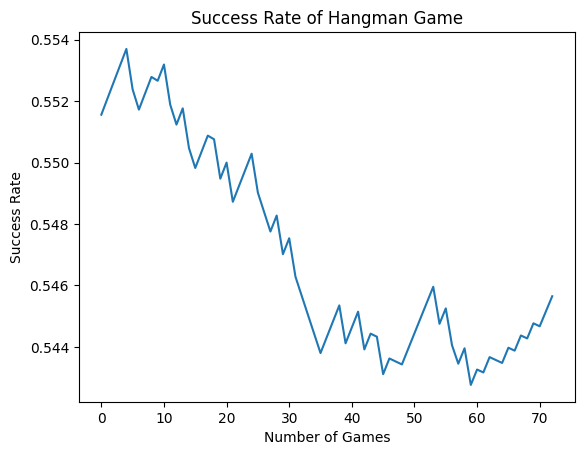

In [54]:
plt.plot(success_rate_list)
plt.xlabel('Number of Games')
plt.ylabel('Success Rate')
plt.title('Success Rate of Hangman Game')
plt.show()

### Here, I use 100 times to take a look at the result. According to my observation, it seems like the parameters will end up the same number show below. As the result, I will just take the final weight for submission.


In [60]:
fivegram=0.340
fourgram=0.327
trigram=0.314 
bigram=0.010 
unigram=0.010

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [67]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False, fivegram=fivegram, fourgram=fourgram, trigram=trigram, bigram=bigram, unigram=unigram)

    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game


HangmanAPIError: {'error': 'Your account has been deactivated!'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [66]:
[total_practice_runs,total_recorded_runs,total_recorded_successes,total_practice_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.529
